<a href="https://colab.research.google.com/github/SWU-SYL/Certificate_project/blob/main/AIproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#%%bash
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1
!pip install konlpy
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

In [7]:
from google.colab import files
myfile1=files.upload()


Saving training.csv to training.csv


In [8]:
from google.colab import files
myfile2=files.upload()


Saving test.csv to test.csv


In [10]:
train_data = pd.read_csv(io.BytesIO(myfile1['training.csv']), encoding='euc-kr')
train_data.head()
test_data = pd.read_csv(io.BytesIO(myfile2['test.csv']), encoding='euc-kr')
test_data.head()

,reviews,label
0,본인의 업무가 아님에도 솔선수범하여 문제를 해결하였다,1
1,간단한 아이디어를 좀 더 화려하게 변형시켜주셨다,1
2,열정적인 태도로 활동에 참여해주셨다,1
3,참고할만한 자료를 많이 보내주셨다,1
4,어려운 내용이었지만 자료가 좋아 이해하기 쉬웠다,1


In [13]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 209


In [14]:
train_data[:5] #상위 5개 출력

,reviews,label
0,동료에게 역부족인 일에는 직접 개입해서 처리한다,1
1,동료의 실패에 대해서도 책임을 회피하지 않는다,1
2,동료간에 갈등이 생겼을 때 중립 적인 입장에서 이를 중재한다,1
3,사람들을 차별대우하지 않는다,1
4,모든 동료들에게 교육훈련 등에 참가할 동등한 기회를 부여한다,1


In [15]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 213


In [16]:
test_data[:5] #상위 5개 출력

,reviews,label
0,본인의 업무가 아님에도 솔선수범하여 문제를 해결하였다,1
1,간단한 아이디어를 좀 더 화려하게 변형시켜주셨다,1
2,열정적인 태도로 활동에 참여해주셨다,1
3,참고할만한 자료를 많이 보내주셨다,1
4,어려운 내용이었지만 자료가 좋아 이해하기 쉬웠다,1


In [21]:
train_data['reviews'].nunique(), train_data['label'].nunique() #데이터에 중복이 있는지 확인

(209, 2)

In [22]:
train_data.drop_duplicates(subset=['reviews'], inplace=True) #리뷰열에서 중복인 내용이 있다면 중복 제거

In [23]:
print('훈련용에서 총 샘플의 개수: ', len(train_data))

훈련용에서 총 샘플의 개수:  209


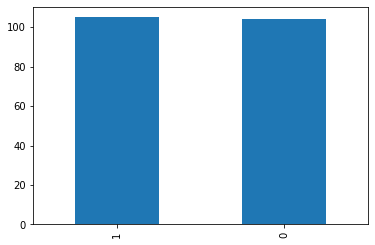

In [24]:
train_data['label'].value_counts().plot(kind='bar') #긍정리뷰 유무 레이블 값을 바 형태로 표현

In [25]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0    104
1      1    105


In [26]:
print(train_data.isnull().values.any())  #True값이면 NULL값 존재

False


In [27]:
print(train_data.isnull().sum()) #NULL값이 어디에 존재하는지 확인

reviews    0
label      0
dtype: int64


In [28]:
train_data.loc[train_data.reviews.isnull()] #NULL값이 어느 인덱스의 위치에 존재하는지 출력

,reviews,label


In [29]:
train_data = train_data.dropna(how='any') #NULL값이 존재하는 행 제거
print(train_data.isnull(). values.any()) #NULL값이 존재하는지 확인

False


In [30]:
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

'do you expect people to read the FAQ etc and actually accept hard atheism'

In [31]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #한글과 공백을 제외하고 모두 제거

In [32]:
train_data['reviews'] = train_data['reviews'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

reviews    0
label      0
dtype: int64


In [33]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [38]:
from konlpy.tag import Okt
okt=Okt()

In [39]:
X_train = []
for sentence in tqdm(train_data['reviews']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 209/209 [00:09<00:00, 21.67it/s] 


In [40]:
print(X_train[:3])

[['동료', '에게', '역', '부족', '인', '일', '에는', '직접', '개입', '처리'], ['동료', '실패', '대해', '서도', '책임', '을', '회피', '않다'], ['동료', '간', '갈등', '생기다', '때', '중립', '적', '인', '입장', '에서', '이르다', '중재']]


In [41]:
X_test = []
for sentence in tqdm(test_data['reviews']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 213/213 [00:00<00:00, 214.52it/s]


In [42]:
print(X_test[:3])

[['본인', '업무', '아니다', '솔선수범', '문제', '해결'], ['간단하다', '아이디어', '더', '화려하다', '변형', '시키다'], ['열정', '적', '인', '태도', '로', '활동', '참여', '해주다']]


In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [46]:
print(tokenizer.word_index) #각 단어에 고유한 정수 부여

{'을': 1, '해주다': 2, '팀': 3, '않다': 4, '있다': 5, '동료': 6, '자다': 7, '적': 8, '일': 9, '목표': 10, '좋다': 11, '못': 12, '대해': 13, '업무': 14, '인': 15, '에게': 16, '되다': 17, '것': 18, '수': 19, '알다': 20, '다': 21, '자신': 22, '의견': 23, '모르다': 24, '사람': 25, '정보': 26, '설정': 27, '맡다': 28, '자료': 29, '모든': 30, '발표': 31, '되어다': 32, '다른': 33, '해오다': 34, '문제': 35, '말': 36, '처리': 37, '때': 38, '에서': 39, '보다는': 40, '회의': 41, '로': 42, '하': 43, '현재': 44, '항상': 45, '정확하다': 46, '활동': 47, '많이': 48, '제시': 49, '고': 50, '이나': 51, '나': 52, '미래': 53, '강조': 54, '갖다': 55, '서다': 56, '시간': 57, '원': 58, '이끌다': 59, '아이디어': 60, '도움': 61, '행동': 62, '진행': 63, '하고': 64, '결과물': 65, '없다': 66, '부족': 67, '자원': 68, '함': 69, '그': 70, '시': 71, '적극': 72, '참여': 73, '시키다': 74, '대화': 75, '속': 76, '실력': 77, '먼저': 78, '본인': 79, '조사': 80, '일이': 81, '높다': 82, '나오다': 83, '많다': 84, '무조건': 85, '경우': 86, '특정': 87, '방식': 88, '만': 89, '무슨': 90, '원인': 91, '책임': 92, '간': 93, '이르다': 94, '위해': 95, '대한': 96, '자주': 97, '환경': 98, '관심': 99, '달성': 100, '내': 101, '가능하

In [47]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 615
등장 빈도가 2번 이하인 희귀 단어의 수: 473
단어 집합에서 희귀 단어의 비율: 76.91056910569107
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 36.084337349397586


In [48]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 143


In [49]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [50]:
print(X_train[:3]) #각 단어에 대한 정수로 변환

[[6, 16, 67, 15, 9, 37], [6, 13, 92, 1, 4], [6, 93, 38, 8, 15, 39, 94]]


In [51]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [53]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
#샘플 길이가 0인 샘플들의 인덱스를 받아옴

In [54]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

206
206


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 15
리뷰의 평균 길이 : 5.150485436893204


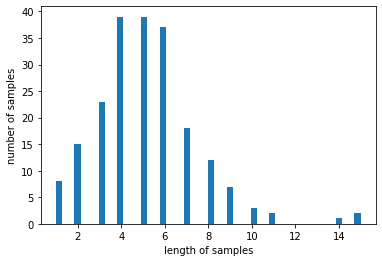

In [55]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [56]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [57]:
max_len = 10  #10이 적당할 것 같음
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 10 이하인 샘플의 비율: 97.57281553398059


In [58]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)  #모든 샘플의 길이를 10으로 맞춤

In [59]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [60]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [61]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [69]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
3/3 [==============================] - ETA: 0s - loss: 0.1519 - acc: 0.9573
Epoch 00001: val_acc did not improve from 0.61446
3/3 [==============================] - 4s 554ms/step - loss: 0.1519 - acc: 0.9573 - val_loss: 2.7769 - val_acc: 0.3333
Epoch 2/15
3/3 [==============================] - ETA: 0s - loss: 0.0497 - acc: 0.9878
Epoch 00002: val_acc did not improve from 0.61446
3/3 [==============================] - 0s 40ms/step - loss: 0.0497 - acc: 0.9878 - val_loss: 2.7454 - val_acc: 0.3810
Epoch 3/15
1/3 [=========>....................] - ETA: 0s - loss: 0.0134 - acc: 1.0000
Epoch 00003: val_acc did not improve from 0.61446
3/3 [==============================] - 0s 39ms/step - loss: 0.0401 - acc: 0.9878 - val_loss: 2.8302 - val_acc: 0.3810
Epoch 4/15
3/3 [==============================] - ETA: 0s - loss: 0.0359 - acc: 0.9878
Epoch 00004: val_acc did not improve from 0.61446
3/3 [==============================] - 0s 43ms/step - loss: 0.0359 - acc: 0.9878 - val_loss: 3.22

In [71]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

7/7 [==============================] - 1s 6ms/step - loss: 1.2785 - acc: 0.5540

 테스트 정확도: 0.5540


In [72]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [73]:
sentiment_predict('너무 열심히해주셨다')

95.02% 확률로 긍정 리뷰입니다.



In [82]:
sentiment_predict('리더십이 있으시다')

76.06% 확률로 긍정 리뷰입니다.



In [92]:
sentiment_predict('열심히 하신다')

80.90% 확률로 긍정 리뷰입니다.



In [100]:
sentiment_predict('배려가 없다')

50.53% 확률로 부정 리뷰입니다.



In [96]:
sentiment_predict('자신의 이득만 취함')

53.34% 확률로 부정 리뷰입니다.

